In [1]:
from datetime import date, timedelta
import import_ipynb
from Simulations import *
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import reduce
import datetime
import pandas as pd
import numpy as np
from re import sub


def dollar_string_to_float(money):
    return float(sub(r'[^\d.]', '', money))


importing Jupyter notebook from Simulations.ipynb


### Company Correlation Matrix

<AxesSubplot:>

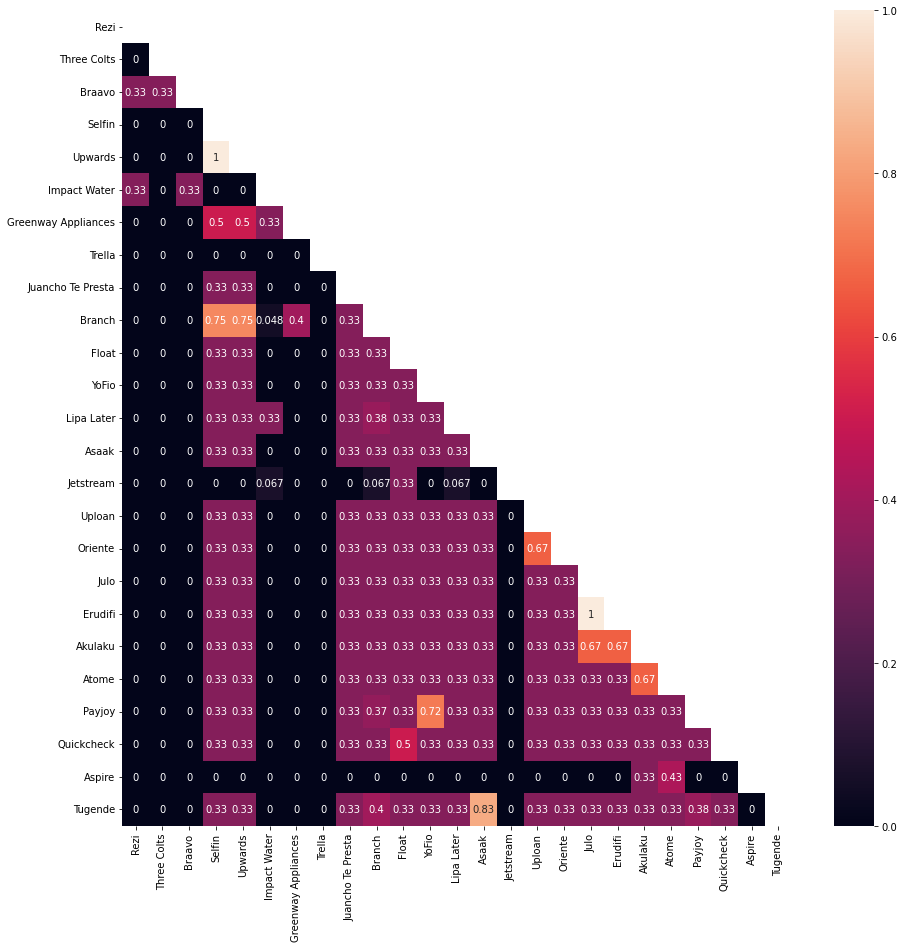

In [2]:
company_info_df = pd.read_csv('company_info.csv')  # Load the company info csv
company_correlation_dict = get_company_correlation(
    company_info_df)  # Compute correlation dict


company_correlation_matrix = np.zeros(
    (len(company_info_df), len(company_info_df)))
company_names = company_info_df['Company Name']
for index1, company1 in company_names.items():
    for index2, company2 in company_names.items():
        company_correlation_matrix[index1][index2] = company_correlation_dict[company1.strip(
        ).lower()][company2.strip().lower()]

mask = np.triu(np.ones_like(company_correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))         # Sample figsize in inches

sns.heatmap(company_correlation_matrix,  # Plot the matrix
            mask=mask,
            xticklabels=company_info_df['Company Name'],
            yticklabels=company_info_df['Company Name'],
            annot=True,
            ax=ax)


### Pool correlation matrix

<AxesSubplot:>

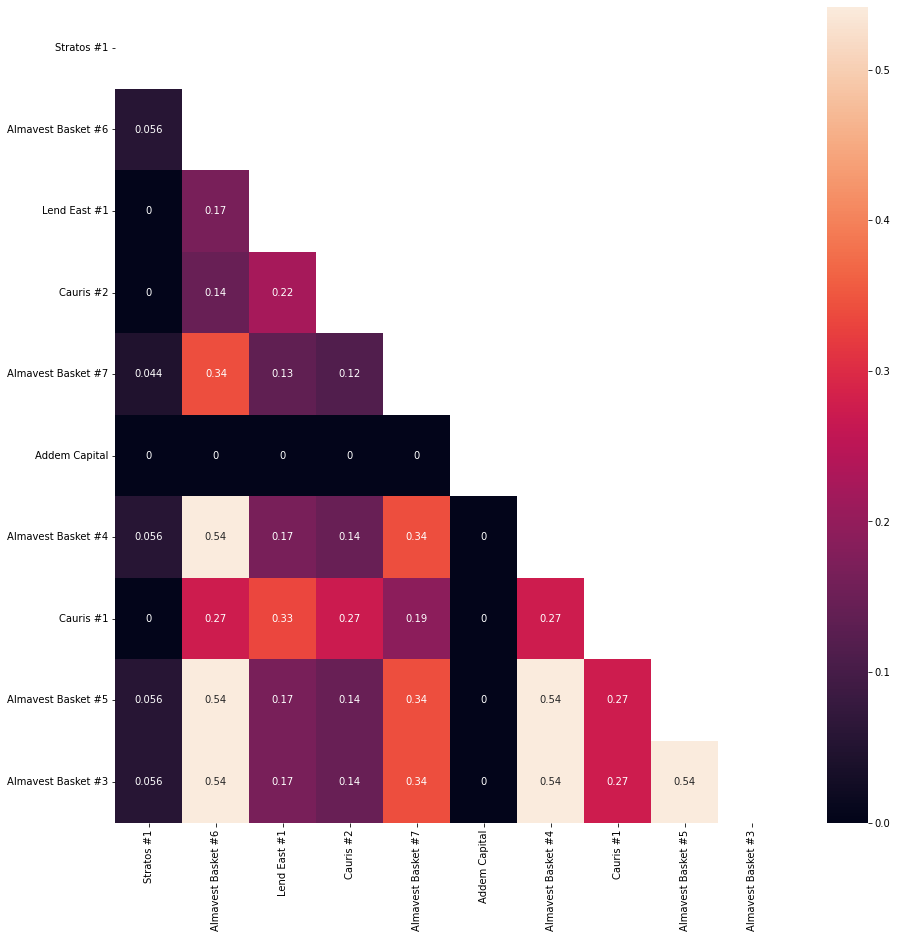

In [3]:
pool_info_df = pd.read_csv('carapace_pool_info.csv')  # Load pool data
pool_info_df['Borrower Companies'] = pool_info_df['Borrower Companies'].fillna(
    "")
pool_correlation_matrix = get_pool_correlation(
    pool_info_df, company_correlation_dict)  # Compute correlation matrix
np.fill_diagonal(pool_correlation_matrix, 1)  # Diagonal values should be 1

# Create mask to remove duplications
mask = np.triu(np.ones_like(pool_correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))         # Sample figsize in inches

# plot the heatmap
sns.heatmap(pool_correlation_matrix,
            mask=mask,
            xticklabels=pool_info_df['Lending Pool Name'],
            yticklabels=pool_info_df['Lending Pool Name'],
            annot=True,
            ax=ax)


In [4]:
low_risk_pool_info_array = []
pool_info_array = []  # Initialize the pool info array
high_risk_pool_info_array = []
for i, row in pool_info_df.iterrows():  # Loop through the pool data
    low_risk_pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": 0.05,"amortization":row["Amortization"]})
    
    
    pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": float(row["Financing Cost"].split("%")[0])/100,"amortization":row["Amortization"]})
    
    high_risk_pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": 0.2,"amortization":row["Amortization"]})
    
    
    # Append info for each pool

low_risk_pool_array = []
high_risk_pool_array = []
pool_array = []  # Initialize the pool array
for pool_info in pool_info_array:  # Loop over the info and create lending pool objects appendign them to list
    pool_array.append(LendingPool(pool_info))
for pool_info in low_risk_pool_info_array:  
    low_risk_pool_array.append(LendingPool(pool_info))
for pool_info in high_risk_pool_info_array: 
    high_risk_pool_array.append(LendingPool(pool_info))

### Regime 1 - Pools are assigned a 5% financing rate to model low riskiness

Initial investment total is  1000
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 0.0
75 percentile capital loss is 0.0
99 percentile capital loss is 215.2471170538019
Mean capital loss is  29.802695167907807


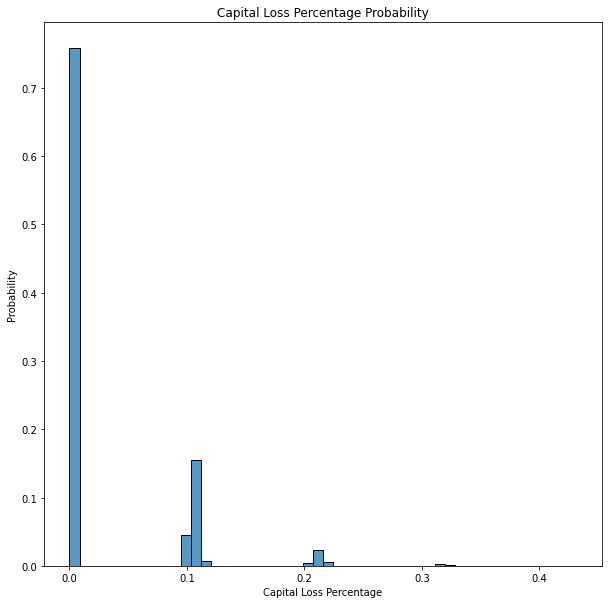

In [5]:
simulation_engine = SimulationEngine(low_risk_pool_array, pool_correlation_matrix)
simulation_engine.simulate_paths(
    pool_array[-1].maturity_date, 50000) 
analysisEngine = AnalysisEngine(
    simulation_engine)  # Initialize analysis engine
initial_investment = [100 for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)

### Regime 2 - Pools are assigned their real world financing rates.

Initial investment total is  1000
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 0.0
75 percentile capital loss is 116.43835616438376
99 percentile capital loss is 350.89904368246425
Mean capital loss is  74.48412295129074


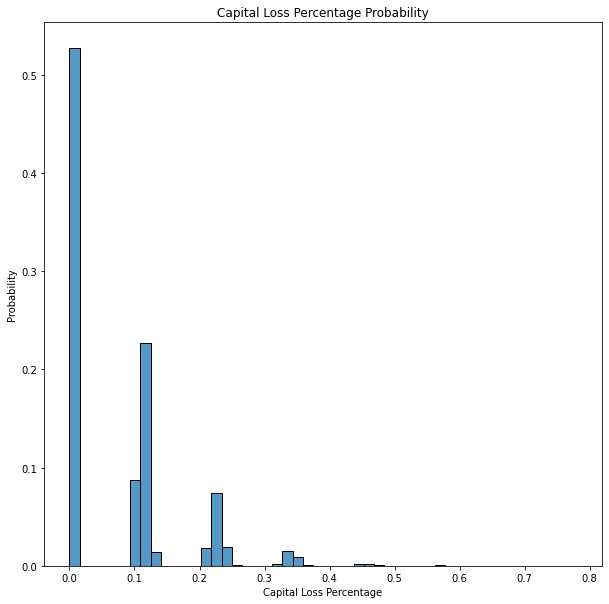

In [6]:
# Initialize the simulation engine
simulation_engine = SimulationEngine(pool_array, pool_correlation_matrix)
simulation_engine.simulate_paths(
    pool_array[-1].maturity_date, 50000)  
analysisEngine = AnalysisEngine(
    simulation_engine)  # Initialize analysis engine
initial_investment = [100 for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)

### Regime 3 - Pools are assigned 20% real world financing rates.

Initial investment total is  1000
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 126.4266144814091
75 percentile capital loss is 246.76127853881297
99 percentile capital loss is 612.6768154077407
Mean capital loss is  156.35802821936133


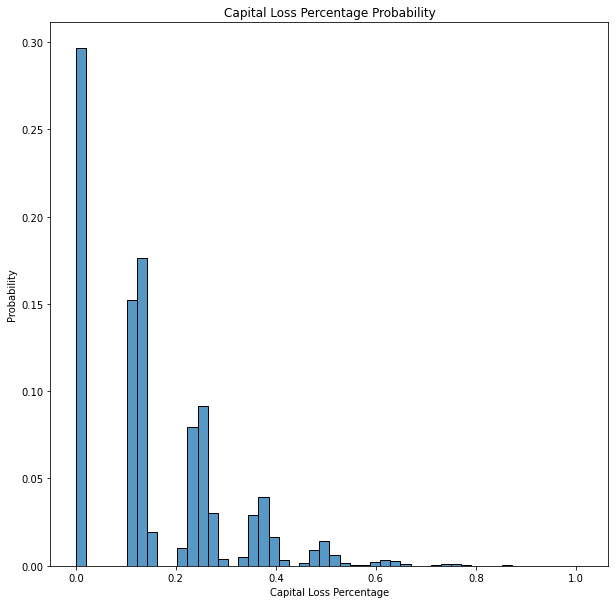

In [7]:
# Initialize the simulation engine
simulation_engine = SimulationEngine(high_risk_pool_array, pool_correlation_matrix)
simulation_engine.simulate_paths(
    pool_array[-1].maturity_date, 50000)  # Run simulations till
analysisEngine = AnalysisEngine(
    simulation_engine)  # Initialize analysis engine
initial_investment = [100 for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)